# FENICS SOLVER

### Import needed packages 

In [1]:
# Get the libraries
import fenics as fn
import numpy as np
import sympy as sym
import scipy as sc
from scipy import constants
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm #Colormap
import meshio as mio
import mshr

In [2]:
mesh = fn.Mesh()
with fn.XDMFFile("meshing/mesh.xdmf") as infile:
    infile.read(mesh)
mvc = fn.MeshValueCollection("size_t", mesh, 2) 
with fn.XDMFFile("meshing/mf.xdmf") as infile:
    infile.read(mvc, "name_to_read")
mf = fn.cpp.mesh.MeshFunctionSizet(mesh, mvc)

In [3]:
M    = 2   #species

Poly    = fn.FiniteElement('Lagrange', mesh.ufl_cell(),2)
Multi   = fn.FiniteElement('Real', mesh.ufl_cell(), 0)
ElemP   = [Poly] * (M+1) 
ElemR   = [Multi] * (M)
Elem    = [ElemP + ElemR][0]
Mixed   = fn.MixedElement(Elem)
V       = fn.FunctionSpace(mesh, Mixed)

In [4]:
# define potentials and concentrations
u_GND  = fn.Expression('0', degree=2)          #Ground
u_DD   = fn.Expression('0.5', degree=2)          #pontential
#c_INIT = fn.Expression('0.01', degree=2)     #concentration on ground
c_avg  = fn.Expression('0.0001', degree=2)    #average concentration

def boundaryGND(x, on_boundary):
    tol=1e-12
    return (x[1] < 0 + tol)

def boundaryHigh(x, on_boundary):
    tol=1e-12
    return (x[1] > 500 - tol)

# set boundary conditions
bcs = []
bcs += [fn.DirichletBC(V.sub(0), u_DD, mf, 5)]
bcs += [fn.DirichletBC(V.sub(0), u_GND, mf, 3)]
#bcs += [fn.DirichletBC(V.sub(i), c_INIT, mf, 1) for i in range(M+1)]
ref_bcs = []
ref_bcs += [fn.DirichletBC(V.sub(0), u_DD, boundaryHigh)]
ref_bcs += [fn.DirichletBC(V.sub(0), u_GND, boundaryGND)]


# define problem
UC    = fn.Function(V)
uc    = fn.split(UC)                        # trial function potential concentration lagrange multi
u, c, lam = uc[0], uc[1:M+1], uc[M+1:]

VW    = fn.TestFunctions(V)                          # test function potential concentration lagrange multi                     
v, w, mu = VW[0], VW[1:M+1], VW[M+1:]


#lets try rot
r = fn.Expression('x[0]', degree=0)
#r = 1
# changing concentrations charges
Rho = 0
for i in range(M):
    if i%2:
        Rho += -c[i]
    else:
        Rho += c[i]

PoissonLeft     = (fn.dot(r*fn.grad(u), fn.grad(v)))*fn.dx                    # weak solution Poisson left
PoissonRight    = -(Rho)*r*v*fn.dx                                  # weak solution Poisson right
NernstPlanck    = 0
for i in range(M):
    if i%2:
        NernstPlanck += fn.dot(r*(-fn.grad(c[i]) + c[i]*fn.grad(u)),fn.grad(w[i]))*fn.dx     # weak solution Nernst-Planck 
    else:
        NernstPlanck += fn.dot(r*(-fn.grad(c[i]) - c[i]*fn.grad(u)),fn.grad(w[i]))*fn.dx     # weak solution Nernst-Planck

constraint = 0
for i in range(M):
    constraint += r*lam[i] * w[i] * fn.dx + r*(c[i] - c_avg) * mu[i] * fn.dx            #constraint a la hoermann
    
        
PNP_xy     = PoissonLeft + PoissonRight + NernstPlanck + constraint        # PNP system
 

In [5]:
# Compute solution
fn.solve(PNP_xy == 0, UC, bcs) # solve function


In [6]:
S1, S2, S3, S4, S5 = UC.split()

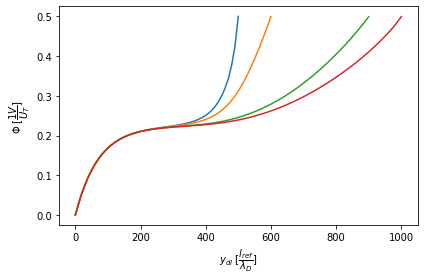

In [7]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(np.linspace(0,500),[S1(0,x,0) for x in np.linspace(0,500)])
ax.plot(np.linspace(0,600),[S1(100,x,0) for x in np.linspace(0,600)])
ax.plot(np.linspace(0,900),[S1(200,x,0) for x in np.linspace(0,900)])
ax.plot(np.linspace(0,1000),[S1(224,x,0) for x in np.linspace(0,1000)])

ax.set_ylabel("$ \Phi\;[\dfrac{1V}{U_T}]$")
ax.set_xlabel("$ y_{dl}\;[\dfrac{l_{ref}}{\lambda_D}]$")
fig.tight_layout()
plt.savefig("POT_ROT.png")

In [8]:
#plt.plot(np.linspace(0,500),[S2(0,x,0) for x in np.linspace(0,500)])
#plt.plot(np.linspace(0,600),[S2(100,x,0) for x in np.linspace(0,600)])
#plt.plot(np.linspace(0,900),[S2(200,x,0) for x in np.linspace(0,900)])
#plt.plot(np.linspace(0,1000),[S2(500,x,0) for x in np.linspace(0,1000)])
S2(500,1000,0)

9.926018320651468e-05

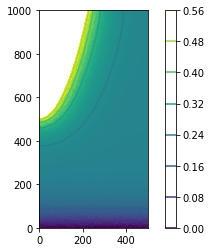

In [9]:
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:,0], xy[:,1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    C = obj.compute_vertex_values(mesh)
    plt.tripcolor(mesh2triang(mesh), C, shading='flat')
    plt.tricontour(mesh2triang(mesh), C)
    plt.colorbar()

plot(S1)

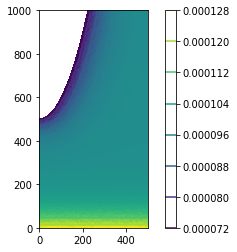

In [10]:
plot(S2)

In [11]:
def plot_tri(obj):
    plt.gca().set_aspect('equal')
    C = obj.compute_vertex_values(mesh)
    plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    plt.tricontour(mesh2triang(mesh), C)
    plt.colorbar()

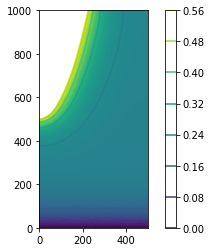

In [12]:
plot_tri(S1)

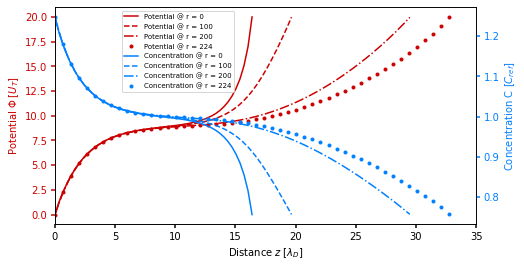

In [15]:
fig, host = plt.subplots()
fig.subplots_adjust(right=1.1)

par1 = host.twinx()


p10, = host.plot(0.0327683*np.linspace(0,500),[S1(0,x,0)*40 for x in np.linspace(0,500)],"-", color="#CC0000", label="Potential @ r = 0")
p11, = host.plot(0.0327683*np.linspace(0,600),[S1(100,x,0)*40 for x in np.linspace(0,600)],"--", color="#CC0000",label="Potential @ r = 100")
p12, = host.plot(0.0327683*np.linspace(0,900),[S1(200,x,0)*40 for x in np.linspace(0,900)], "-.",color="#CC0000", label="Potential @ r = 200")
p13, = host.plot(0.0327683*np.linspace(0,1000),[S1(224,x,0)*40 for x in np.linspace(0,1000)],".", color="#CC0000", label="Potential @ r = 224")

p20, = par1.plot(0.0327683*np.linspace(0,500),[S2(0,x,0)*10000 for x in np.linspace(0,500)],"-", color="#0080FF", label="Concentration @ r = 0")
p21, = par1.plot(0.0327683*np.linspace(0,600),[S2(100,x,0)*10000 for x in np.linspace(0,600)],"--", color="#0080FF",label="Concentration @ r = 100")
p22, = par1.plot(0.0327683*np.linspace(0,900),[S2(200,x,0)*10000 for x in np.linspace(0,900)],"-.", color="#0080FF", label="Concentration @ r = 200")
p23, = par1.plot(0.0327683*np.linspace(0,1000),[S2(224,x,0)*10000 for x in np.linspace(0,1000)],".", color="#0080FF", label="Concentration @ r = 224")


host.set_xlim(0, 35)
#host.set_ylim(0, 0.5)
#par1.set_ylim(0.008, 0.013)


host.set_xlabel("Distance $ z\;[\lambda_D]$")
host.set_ylabel("Potential $ \Phi\;[U_T]$")
par1.set_ylabel("Concentration C $ [C_{ref}] $")


host.yaxis.label.set_color(p10.get_color())
par1.yaxis.label.set_color(p20.get_color())


tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p10.get_color(), **tkw)
par1.tick_params(axis='y', colors=p20.get_color(), **tkw)

host.tick_params(axis='x', **tkw)

lines = [p10,p11,p12,p13,p20,p21,p22,p23]

host.legend(lines, [l.get_label() for l in lines], loc="upper left", fontsize="x-small", bbox_to_anchor=(0.15, 1))
plt.savefig("ROT_PLOT.png", bbox_inches = 'tight', dpi=1200)
plt.show()